# The Collatz Conjecture

Start with a number. If it's even, halve it. Otherwise, multiply by 3 then add 1. Repeat.

The [Collatz Conjecture](https://en.wikipedia.org/wiki/Collatz_conjecture) suggests that, if you follow this process starting at **any** positive integer, you'll always get back to 1 eventually.

Let's say that the "*If it's even, halve it. Otherwise, multiply by 3 then add 1.*" part is a "step".

In [1]:
def even(n):
    return not n % 2

def step(n):
    if even(n):            # If it's even,
        return n // 2      # halve it.
    else:                  # Otherwise,
        return 3*n + 1     # multiply by 3 then add 1.
        


For example, let's start with 13.

13 is odd -> 3n + 1 -> 40  
40 is even -> halve -> 20  
20 is even -> halve -> 10  
10 is even -> halve -> 5  
5 is odd -> 3n + 1 -> 16  
16 is even -> halve -> 8  
8 is even -> halve -> 4  
4 is even -> halve -> 2  
2 is even -> halve -> 1  


In [2]:
assert step(13) == 40
assert step(40) == 20
assert step(20) == 10
assert step(10) == 5
assert step(5) == 16
assert step(16) == 8
assert step(8) == 4
assert step(4) == 2
assert step(2) == 1

You can build a sequence of numbers for any starting number by simply repeating the `step` until you get to 1.

In [3]:
def make_collatz(n):
    series = [n]
    while n != 1:
        n = step(n)
        series.append(n)
    return series

make_collatz(13)

[13, 40, 20, 10, 5, 16, 8, 4, 2, 1]

If you like generators, you can do it as a generator  
(with the added advantage that you can avoid running forever if we happen to disprove the collatz conjecture!)

In [4]:
def generate_collatz(n):
    yield n
    while n != 1:
        n = step(n)
        yield n
        
list(generate_collatz(13))

[13, 40, 20, 10, 5, 16, 8, 4, 2, 1]

Or... you could even do it recursively  
(with the caveat that we might hit the python recursion limit for large numbers, BUT memoization could help a lot)

In [5]:
def recurse_collatz(n, series=None):
    series = series or []
    series.append(n)
    
    if n == 1:
        return series
    
    return recurse_collatz(step(n), series)
    
recurse_collatz(13)

[13, 40, 20, 10, 5, 16, 8, 4, 2, 1]

And hopefully we haven't made any mistakes

In [6]:
for i in range(1, 100): 
    assert make_collatz(i) == recurse_collatz(i) == list(generate_collatz(i))

Nice!

Let's choose our favourite implementation. Change this if you want to try the others!

In [7]:
collatz = lambda x: list(generate_collatz(x))
# collatz = recurse_collatz
# collatz = make_collatz

It would be nice to see what's going on though, right?

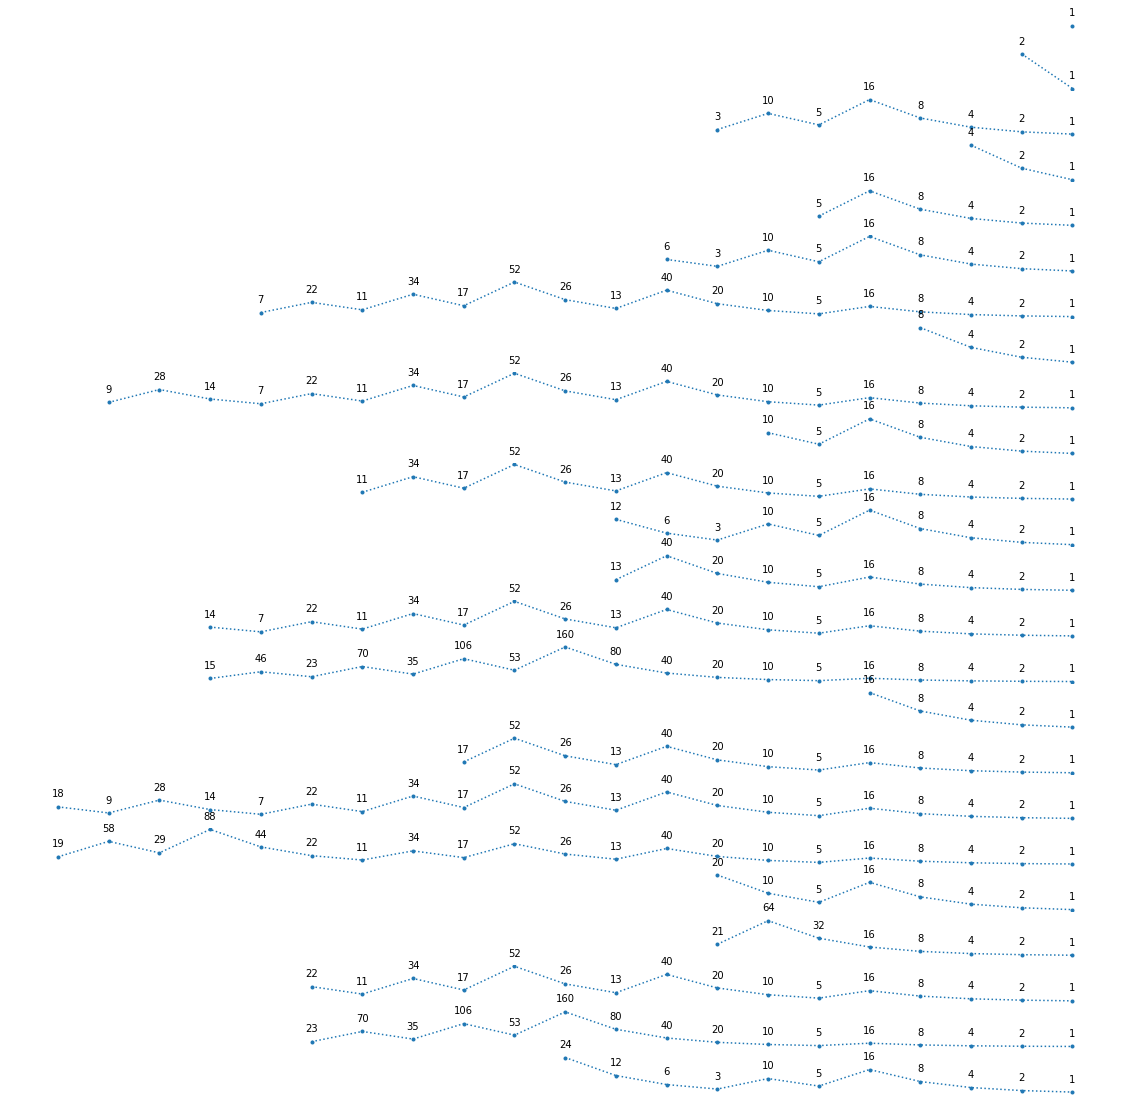

In [8]:
import matplotlib.pyplot as plt

N = 25

lines = []
for i in range(1, N):
    vals = collatz(i)
    lines.append(vals)
    
longest = max(len(ys) for ys in lines)
xs = [x - longest for x in range(longest)]


fig, axs = plt.subplots(N-1, 1, figsize=[20, 20], sharex=True)

for ax, vals in zip(axs, lines):
    ys = [None for _ in range(len(xs) - len(vals))] + vals
    ax.plot(xs, ys, '.:')
    ax.axis('off')
    
    for x, y in zip(xs, ys):
        if not y:
            continue
        ax.annotate(
            text=int(y),
            xy=(x, y),
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
        ) 
    
plt.show()

Hmmm... there are a few interesting things we can see:


1. Many series end in the same numbers.... `..., 10, 5, 16, 8, 4, 2, 1`  
    It kind of makes sense. No matter how you get to the number 10, then you're going to follow the same path down to 1.  
    
  
2. There are never more than two ways to get to a number.  
    - You always have x/2 to get to it. e.g. `20 / 2 = 10`
    - And sometimes you also have 3x+1 to get to it. e.g. `3 * 3 + 1 = 10` 
      

3. You never have two 3x + 1 steps in a row.  
    This is because 3x + 1 **always** gives an even number.  
    However, there are often multiple consecutive x/2 steps
    
### Work Backwards

Points 1. and 2. above make me think of something interesting.

What if, instead of starting with the number, and checking if it gets to 1, we could instead start with 1 and build up all the different ways to get to it.

This might be quicker, because it would avoid all the repetition we're seeing above.
> Side note: Another way of dealing with all this repitition is to use memoization with our recursive function above.

So let's try working backwards:

In [9]:
def valid(n):
    positive = n > 0
    integer = n.is_integer()
    odd = n % 2
    return positive and integer and odd

def step_back(n):
    double = int(2*n)                # the inverse of x/2
    three_x_1 = (n - 1) / 3          # the inverse of 3x + 1
    
    if valid(three_x_1):
        return {double, int(three_x_1)}
    
    else:
        return {double}

    
assert step_back(10) == {20, 3}    
assert step_back(5) == {10}
assert step_back(7) == {14}  # should not give "2", since it is even.

`step_back` gives us all (one or two) values which would `step()` to n.

So, using this, let's generate some numbers which we know must eventually Collatz down to 1.

In [10]:
from queue import Queue

def backward_collatz(limit, seed=1):
    candidates = Queue()
    candidates.put(seed)

    done = set()

    i = limit
    while i > 0:
        n = candidates.get()
        new_candidates = step_back(n)
        for candidate in new_candidates:
            if candidate not in done:
                candidates.put(candidate)
        done.add(n)
        i -= 1
        
    return done
        
Ns = backward_collatz(25)
Ns

{1,
 2,
 3,
 4,
 5,
 6,
 8,
 10,
 12,
 13,
 16,
 20,
 21,
 32,
 40,
 42,
 64,
 80,
 84,
 85,
 128,
 170,
 256,
 512,
 1024}

> **Side note**  
> One interesting thing I noticed:
>
> Some numbers (like 7) don't appear in this list, even though much higher numbers (like 1024) do.  
> It feels like we have "missed" some numbers.... but since
> - this function is basically a breadth first search, and 
> - 7 is *more steps* away from 1 than 1024 is, and
> - we didn't get "far enough" to reach 7 before reaching the limit,
> 
> this makes sense.

So this is kind of an interesting representation. We're just ending up with some numbers that are Collatzible.

Although, Collatz conjects that *all* numbers are Collatzible, and no one has found a counterexample yet... so it's not that interesting to just return a list of Collatzible numbers!

Maybe we could find a better representation that somehow describes the structure or relationship between the numbers

In [11]:
for n in sorted(Ns):
    print(list(collatz(n)))

[1]
[2, 1]
[3, 10, 5, 16, 8, 4, 2, 1]
[4, 2, 1]
[5, 16, 8, 4, 2, 1]
[6, 3, 10, 5, 16, 8, 4, 2, 1]
[8, 4, 2, 1]
[10, 5, 16, 8, 4, 2, 1]
[12, 6, 3, 10, 5, 16, 8, 4, 2, 1]
[13, 40, 20, 10, 5, 16, 8, 4, 2, 1]
[16, 8, 4, 2, 1]
[20, 10, 5, 16, 8, 4, 2, 1]
[21, 64, 32, 16, 8, 4, 2, 1]
[32, 16, 8, 4, 2, 1]
[40, 20, 10, 5, 16, 8, 4, 2, 1]
[42, 21, 64, 32, 16, 8, 4, 2, 1]
[64, 32, 16, 8, 4, 2, 1]
[80, 40, 20, 10, 5, 16, 8, 4, 2, 1]
[84, 42, 21, 64, 32, 16, 8, 4, 2, 1]
[85, 256, 128, 64, 32, 16, 8, 4, 2, 1]
[128, 64, 32, 16, 8, 4, 2, 1]
[170, 85, 256, 128, 64, 32, 16, 8, 4, 2, 1]
[256, 128, 64, 32, 16, 8, 4, 2, 1]
[512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]


What if, instead, we used a tree to represent this information?  
It is, after all, binary tree information

In [12]:
from ete3 import Tree

def grow(node, done):
    n = node.name
    candidates = step_back(n)
    for candidate in candidates:
        if candidate not in done:
            node.add_child(name=candidate)

def tree_collatz(limit, seed=1):
    t = Tree(name=seed)
    nodes = [t]
    
    done = set()
    i = limit
    while i > 0:
        children = []
        for node in nodes:
            grow(node, done)
            children.extend(node.children)
            done.add(node.name)
            i -= 1
            
        nodes = children
        
        
    return t

Nice. So now we have a function to set up our tree. Let's decorate it!

In [13]:
# to run this you have to have pyqt5 installed.
# sudo apt install python3-pyqt5
# pip install PyQt5

from ete3 import TreeStyle, AttrFace, NodeStyle
import random


def decorate(tree, highlight_startpoint=None):
    if highlight_startpoint:
        highlight_path = set(collatz(highlight_startpoint))
    else:
        highlight_path = set()


    node_style = NodeStyle()
    node_style["hz_line_type"] = 0
    node_style["hz_line_color"] = "#888888"
    node_style["vt_line_type"] = 0
    node_style["vt_line_color"] = "#888888"
    node_style["size"] = 0

    face = AttrFace("name", fsize=10)
    face.margin_bottom = 20
    face.rotation = 90

    highlight_style = NodeStyle()
    highlight_style["hz_line_width"] = 5
    highlight_style["hz_line_color"] = "DodgerBlue"
    highlight_style["vt_line_type"] = 0
    highlight_style["vt_line_color"] = "#888888"
    highlight_style["size"] = 0

    highlight_face = AttrFace("name", fsize=10, fgcolor="DodgerBlue")
    highlight_face.margin_bottom = 20
    highlight_face.rotation = 90

    for node in tree.traverse():
        if node.name in highlight_path:
            node.add_face(highlight_face, column=0, position = "branch-right")
            node.set_style(highlight_style)
        else:
            node.add_face(face, column=0, position = "branch-right")
            node.set_style(node_style)


    style = TreeStyle()
    style.mode = "c" # circular mode
    style.scale = 10
    style.arc_start = 95
    style.arc_span = 180
    style.rotation = 270
    style.show_leaf_name = False
    style.show_scale = False
    
    return style


Let's see what it looks like!

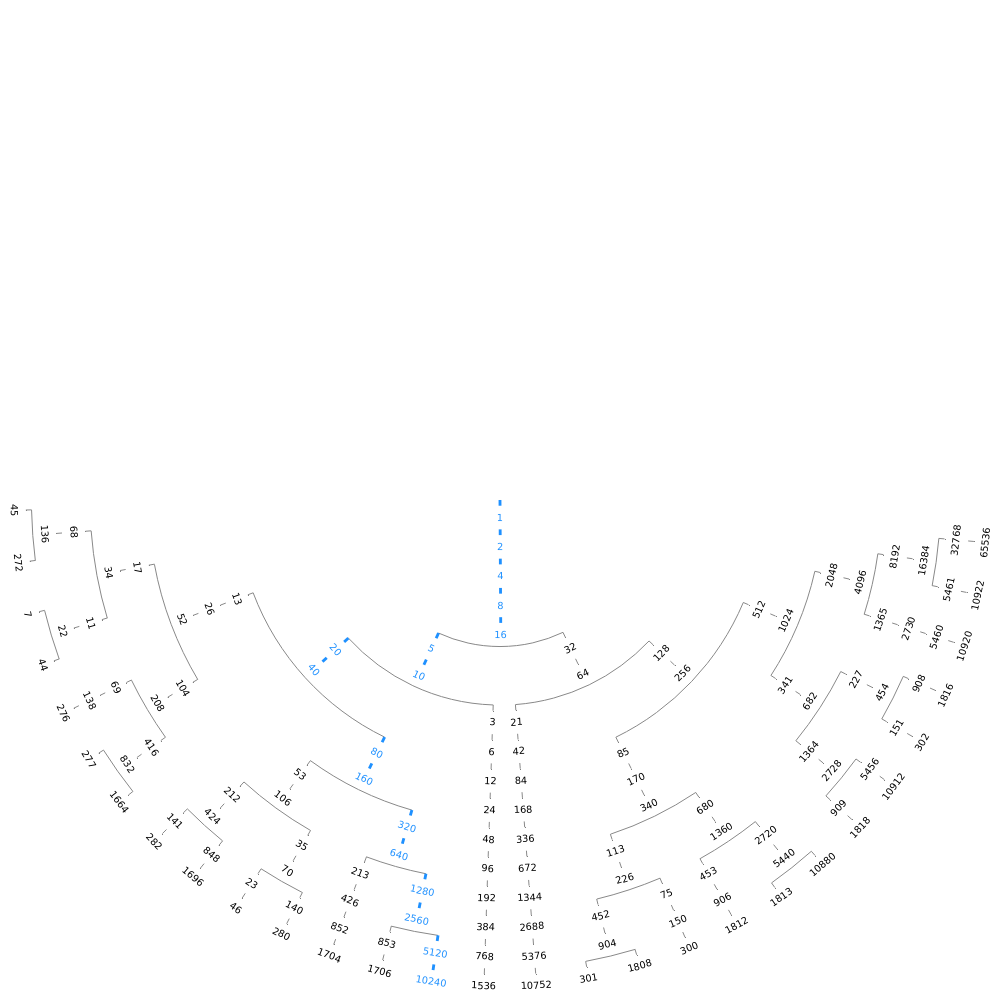

In [14]:
tree = tree_collatz(100, 1)

# We'll highlight a random path through the tree, but you can set
# highlight_startpoint to any integer in the tree and its path will be highlighted
highlight_startpoint = random.choice(tree.get_leaves()).name

style = decorate(tree, highlight_startpoint)
tree.render("%%inline", w=1000, tree_style=style)  

I kind of want to show more depth, more numbers... but it's a little difficult to squash it in to that space.

Maybe we could continue growing the tree just from our "start number", and grow a whole tree around that?

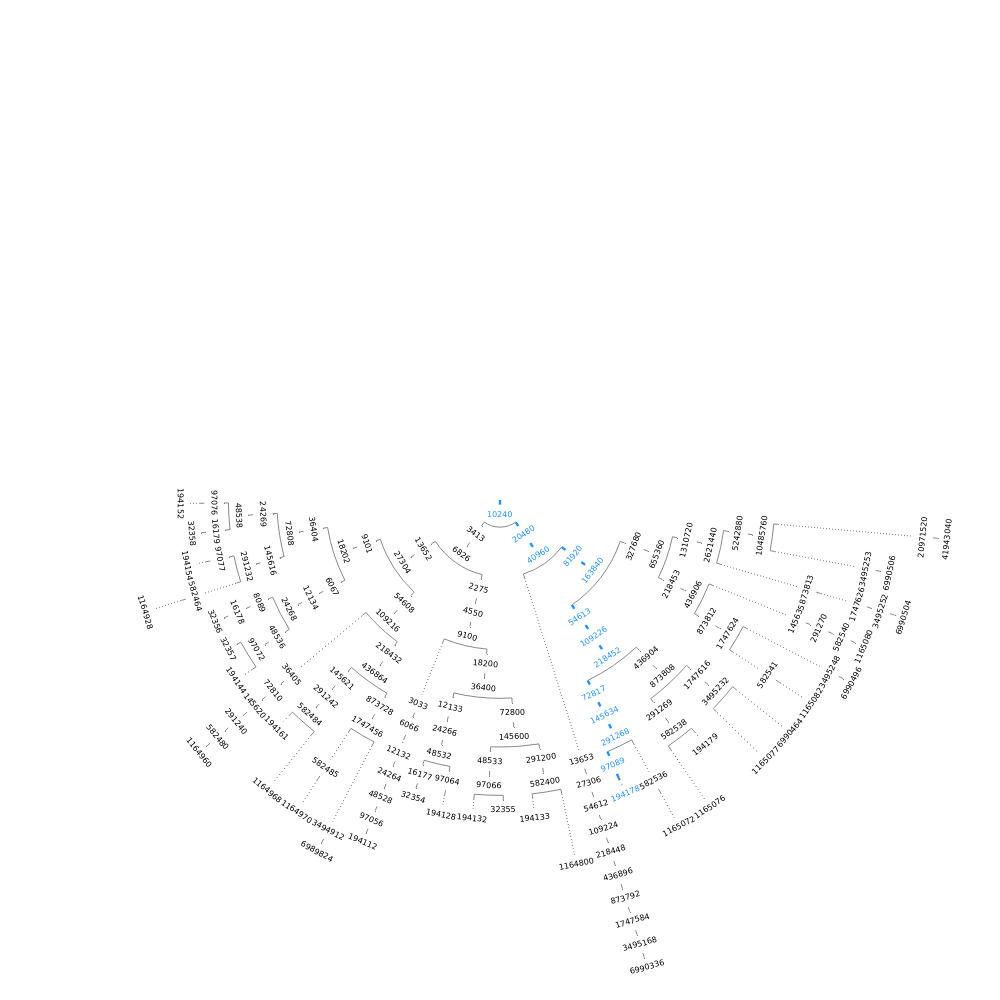

In [15]:
tree = tree_collatz(100, highlight_startpoint)
highlight_startpoint = random.choice(tree.get_leaves()).name
style = decorate(tree, highlight_startpoint)
tree.render("%%inline", w=1000, tree_style=style)  

OK, so that's kind of cool.

I would like to do better, but right now I haven't figured out how. 

The ideal would be to have an interactive graph where I could zoom in on particular sections or paths, and (maybe) lazily generate each part of the tree as I go along.

Everything below here is "under development".... will come back to this later :)

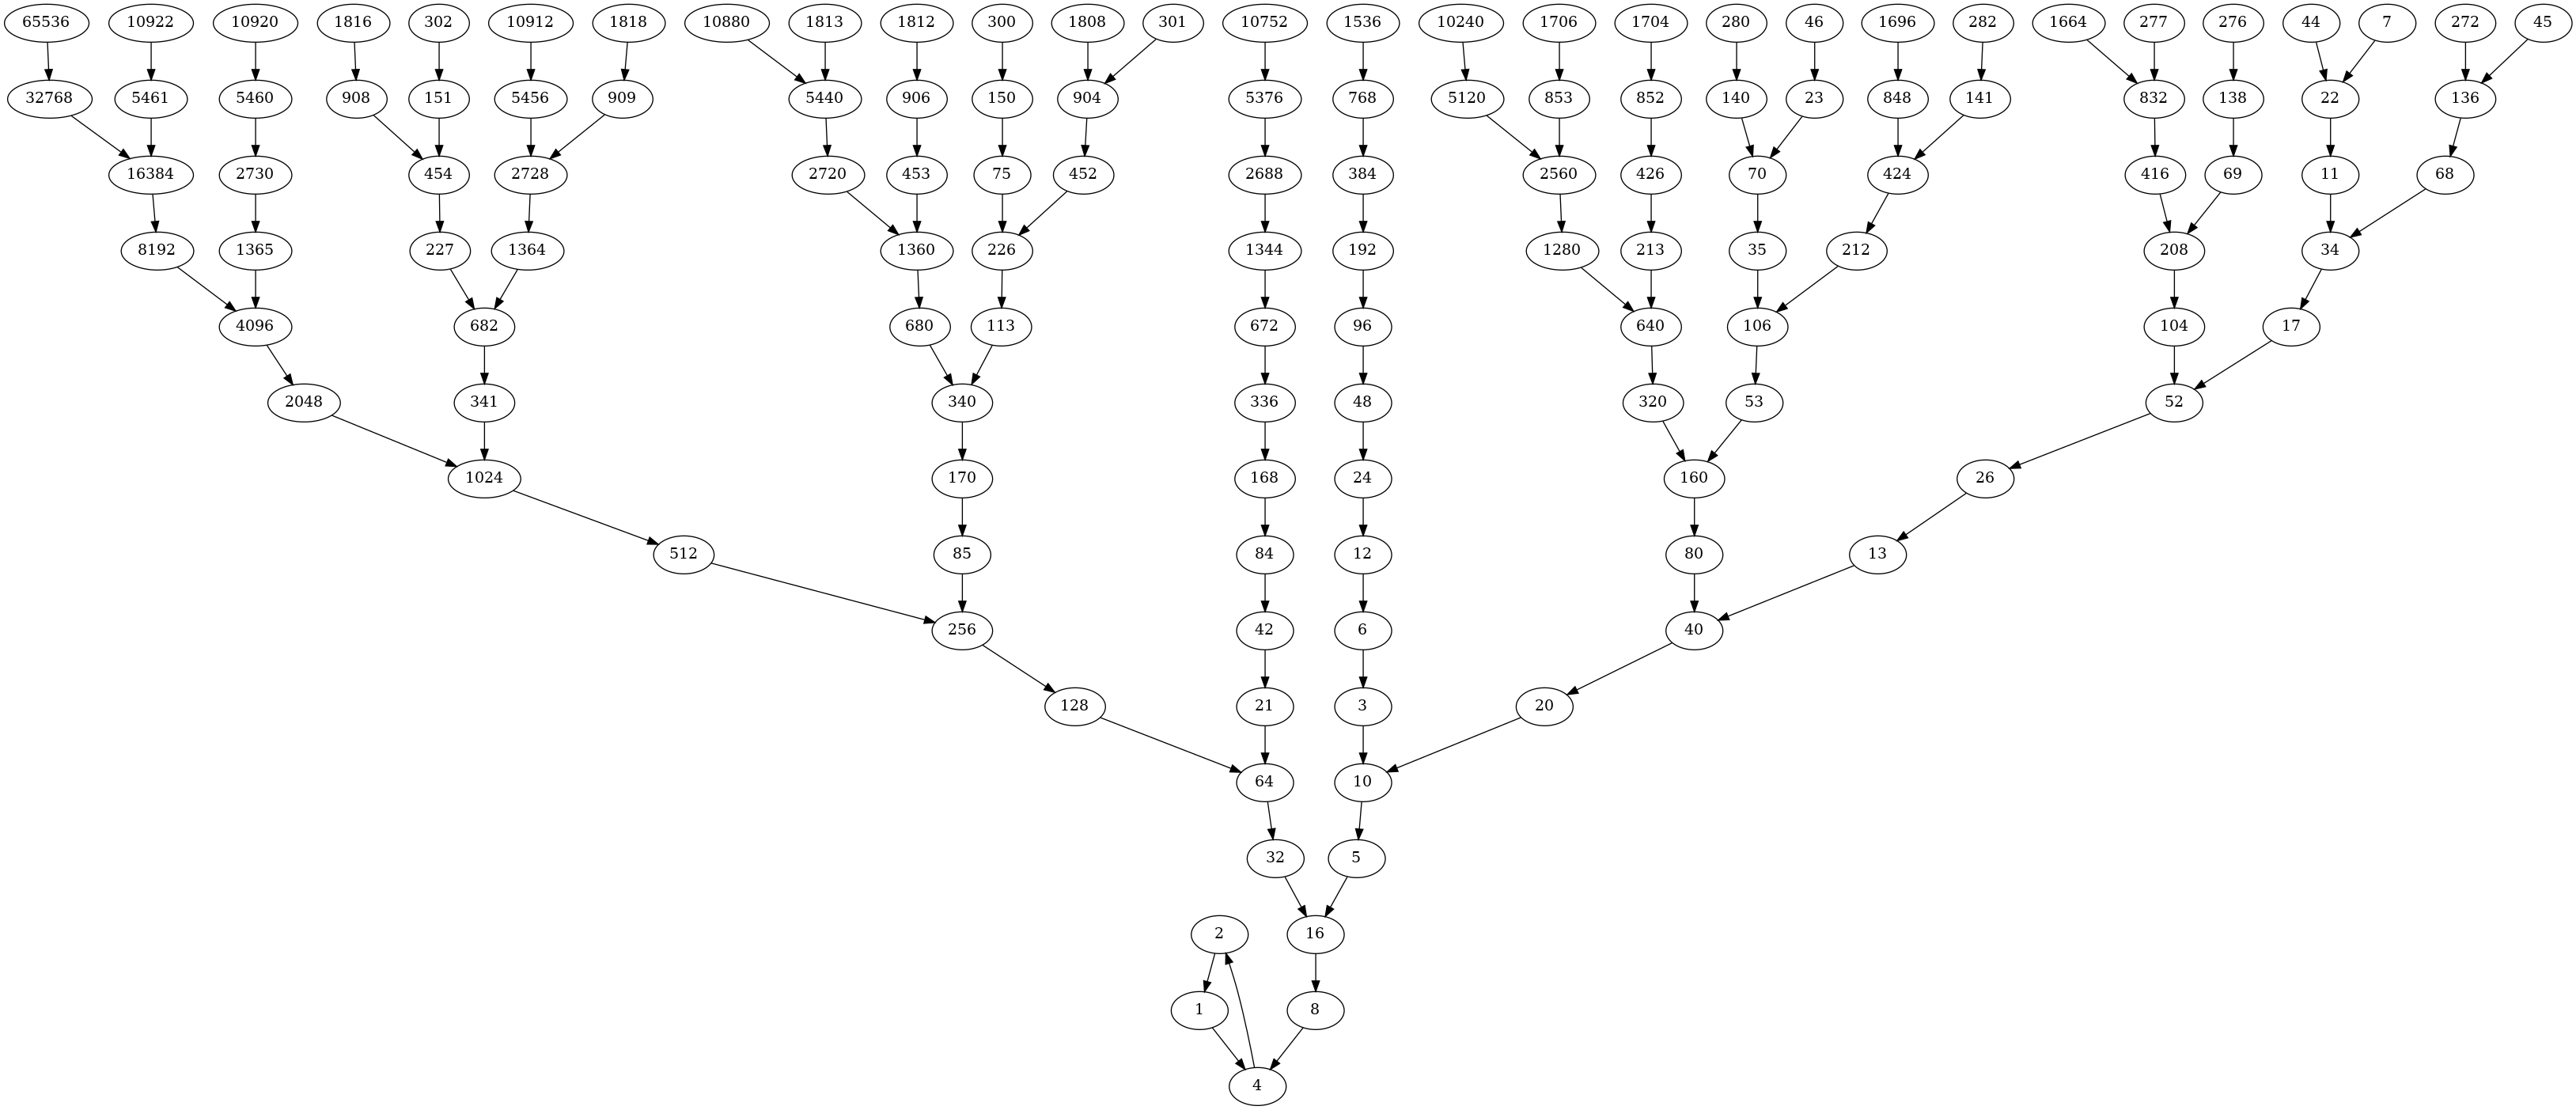

In [16]:
import networkx as nx
from bokeh.io import output_notebook, show


def grow_collatz(limit, seed=1):
    G = nx.DiGraph()
    
    done = set()
    
    layer = [seed]
    i = limit
    while i > 0:
        next_layer = set()
        for parent in layer:
            i -= 1
            for node in step_back(parent):
#                 G.add_edge(parent, node)
                G.add_edge(node, parent)
                next_layer.add(node)
        layer = next_layer
                
    return G

from bokeh.plotting import figure, from_networkx

G = grow_collatz(150)

# sudo apt install python3-pydot graphviz
# pip install pydot
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from IPython.display import Image, display

# pos = graphviz_layout(G, prog="twopi")
# nx.draw(G, pos)
# plt.show()
        
p=nx.drawing.nx_pydot.to_pydot(G)
image = Image(p.create_png())
display(image)
